<a href="https://colab.research.google.com/github/Torough/BEASTDL/blob/master/Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive'
           )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import sklearn

import random
import keras
import sys, cv2, glob, os, time
from tqdm import tqdm
from sklearn import metrics, svm, metrics

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential, Model
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten, Input, BatchNormalization, Activation, Dropout

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


from keras.layers import  MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet


from os import listdir
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import copy

Using TensorFlow backend.


In [0]:





protoFile =    "/content/gdrive/My Drive/project/openpose-master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile =  "/content/gdrive/My Drive/project/openpose-master/pose_iter_160000.caffemodel"
 
# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)





CATEGORIES = ["Anger", "Fear", "Happy", "Sad"]

DATADIR = "/content/gdrive/My Drive/project/BEASTskeleton/"
skeleton_data = []
inWidth = 138
inHeight = 310 

def create_skeleton_data():
    for category in CATEGORIES:  # 

        path = os.path.join(DATADIR,category)  # create path to Emotion categories
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            
                #img_array = cv2.imread(os.path.join(path,img)) 
                img_array = cv2.imread(os.path.join(path,img) )  # convert to array
                #img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (224, 224))  # resize to normalize data size
                #new_array = cv2.resize(img_array, (138, 310))  # resize to normalize data size
                
                          
                
                # Read image
                frame = new_array

                # Specify the input image dimensions

                frameCopy = np.copy(frame)
                frameWidth = frame.shape[1]
                frameHeight = frame.shape[0]
                threshold = 0.1

                # Prepare the frame to be fed to the network
                inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

                # Set the prepared object as the input blob of the network
                net.setInput(inpBlob)


                output = net.forward()              
                H = output.shape[2]
                W = output.shape[3]
                # Empty list to store the detected keypoints
                points = []
                for i in range(15):
                    # confidence map of corresponding body's part.
                    probMap = output[0, i, :, :]

                    # Find global maxima of the probMap.
                    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

                    # Scale the point to fit on the original image
                    x = (frameWidth * point[0]) / W
                    y = (frameHeight * point[1]) / H

                    if prob > threshold :
                        cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
                        #cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 3, lineType=cv2.LINE_AA)

                        # Add the point to the list if the probability is greater than the threshold
                        points.append((int(x), int(y)))
                    else :
                        points.append(None)


                POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

                for pair in POSE_PAIRS:
                    partA = pair[0]
                    partB = pair[1]

                    if points[partA] and points[partB]:
                        cv2.line(frameCopy, points[partA], points[partB], (0, 255, 0), 3)

            
                
                skeleton_data.append([frameCopy, class_num])  # add this to our training_data
            #except Exception as e:  # in the interest in keeping the output clean...
            #   pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_skeleton_data()

#print(len(training_data))


100%|██████████| 62/62 [02:04<00:00,  2.02s/it]


In [0]:
this = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in this.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in this.layers:
    print(layer, layer.trainable)
    

# Create the model
trainer = models.Sequential()
 
# Add the vgg convolutional base model
trainer.add(this)
 
# Add new layers
trainer.add(layers.Flatten())
trainer.add(layers.Dense(1024, activation='relu'))
trainer.add(layers.Dropout(0.5))
trainer.add(layers.Dense(4, activation='softmax'))



trainer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


<keras.engine.input_layer.InputLayer object at 0x7f752a33e5c0> False
<keras.layers.convolutional.Conv2D object at 0x7f752a33e470> False
<keras.layers.convolutional.Conv2D object at 0x7f752a33eb70> False
<keras.layers.pooling.MaxPooling2D object at 0x7f752a2ecbe0> False
<keras.layers.convolutional.Conv2D object at 0x7f752a2ec630> False
<keras.layers.convolutional.Conv2D object at 0x7f752a30db38> False
<keras.layers.pooling.MaxPooling2D object at 0x7f752a320da0> False
<keras.layers.convolutional.Conv2D object at 0x7f752a320400> False
<keras.layers.convolutional.Conv2D object at 0x7f752a2d03c8> False
<keras.layers.convolutional.Conv2D object at 0x7f752a2637b8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f752a2796d8> False
<keras.layers.convolutional.Conv2D object at 0x7f752a279828> False
<keras.layers.convolutional.Conv2D object at 0x7f752a228c88> False
<keras.layers.convolutional.Conv2D object at 0x7f752a240f98> False
<keras.layers.pooling.MaxPooling2D object at 0x7f752a1ef1d0>

In [0]:
def aug(model):
  History = model.fit_generator(train_gen,                                
                    steps_per_epoch=len(X_train) / 32, validation_data = val_datagen, 
                    validation_steps=32, epochs=30)
  return History

In [0]:
def no_aug(model):
  History = model.fit( X_train,y_train, validation_split=0.3, epochs=30)
  
  return History

In [0]:
def plot_confusion_matrix(classifier):
  predictions = classifier.predict(X_test)
  
  matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)) 
  return sns.heatmap(matrix,annot=True,fmt='.5g')

In [0]:
def scores(classifier):
  predictions = classifier.predict(X_test)
  
  test_score = classifier.evaluate(X_test, y_test)
  print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))
  
  print('=========================================================================================')
  
  print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))))
  
  print('=========================================================================================')
  
  matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
  #print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predictions))
  print(matrix)

In [0]:
def graph(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_gen = datagen.flow(
    x=X_train, y=y_train,
    subset='training',
    #class_mode = 'categorical'
    
                        )
 
val_datagen = datagen.flow(
    x=X_train, y=y_train,
    subset='validation',
    #class_mode = 'categorical'
                        )
   
datagen.fit(X_train)

In [0]:
Features = []
y = []

for features,label in skeleton_data:
    Features.append(features)
    y.append(label)
    
    
#Resizing Image Data
X = np.array(Features).reshape(-3,224, 224 , 3)
#one Hot Encoding
y = to_categorical(y)  

In [0]:
X = np.array(Features)

In [0]:
X.shape

(254, 310, 138, 3)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


In [0]:
Skeleton_aug = aug(trainer)

W0818 04:00:07.603889 140144055474048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
6/5 [==============================] - 22s 4s/step - loss: 2.6021 - acc: 0.2949 - val_loss: 1.2535 - val_acc: 0.3766
Epoch 2/30
6/5 [==============================] - 10s 2s/step - loss: 1.2621 - acc: 0.3975 - val_loss: 1.3178 - val_acc: 0.3224
Epoch 3/30
6/5 [==============================] - 10s 2s/step - loss: 1.1101 - acc: 0.4790 - val_loss: 0.8664 - val_acc: 0.6579
Epoch 4/30
6/5 [==============================] - 10s 2s/step - loss: 0.9005 - acc: 0.6048 - val_loss: 0.8551 - val_acc: 0.6628
Epoch 5/30
6/5 [==============================] - 10s 2s/step - loss: 0.9069 - acc: 0.6090 - val_loss: 0.6618 - val_acc: 0.7286
Epoch 6/30
6/5 [==============================] - 10s 2s/step - loss: 0.6351 - acc: 0.7096 - val_loss: 0.5143 - val_acc: 0.8010
Epoch 7/30
6/5 [==============================] - 10s 2s/step - loss: 0.6837 - acc: 0.7066 - val_loss: 0.5006 - val_acc: 0.8043
Epoch 8/30
6/5 [==============================] - 10s 2s/step - loss: 0.4616 - acc: 0.8136 - val_loss: 1

64/64 [==============================] - 1s 9ms/step
Test loss 1.5784, accuracy 89.06%
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f75779554a8>:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       1.00      0.59      0.74        17
           2       0.88      1.00      0.94        15
           3       1.00      1.00      1.00        16

    accuracy                           0.89        64
   macro avg       0.91      0.90      0.89        64
weighted avg       0.91      0.89      0.88        64


[[16  0  0  0]
 [ 5 10  2  0]
 [ 0  0 15  0]
 [ 0  0  0 16]]


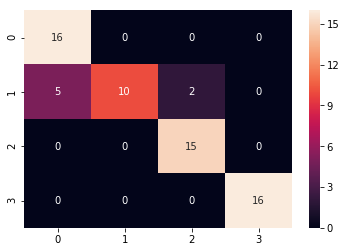

In [0]:
plot_confusion_matrix(trainer)

scores(trainer)

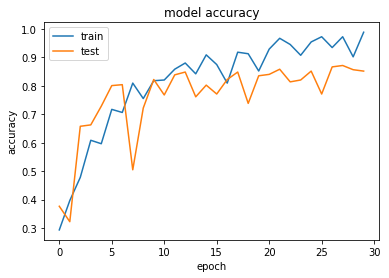

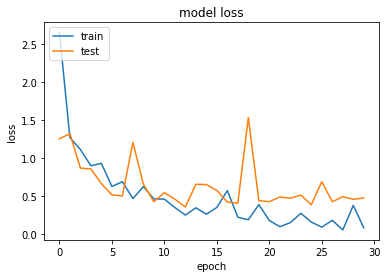

In [0]:
graph(Skeleton_aug)

In [0]:
Skeleton_naug = no_aug(trainer)

Train on 133 samples, validate on 57 samples
Epoch 1/30
133/133 [==============================] - 6s 49ms/step - loss: 11.9990 - acc: 0.2256 - val_loss: 13.8559 - val_acc: 0.1404
Epoch 2/30
133/133 [==============================] - 2s 16ms/step - loss: 10.2904 - acc: 0.3459 - val_loss: 8.2004 - val_acc: 0.4912
Epoch 3/30
133/133 [==============================] - 2s 16ms/step - loss: 11.0344 - acc: 0.3008 - val_loss: 12.6529 - val_acc: 0.1930
Epoch 4/30
133/133 [==============================] - 2s 16ms/step - loss: 10.4140 - acc: 0.3383 - val_loss: 11.2624 - val_acc: 0.2807
Epoch 5/30
133/133 [==============================] - 2s 16ms/step - loss: 10.7973 - acc: 0.3158 - val_loss: 11.6282 - val_acc: 0.2456
Epoch 6/30
133/133 [==============================] - 2s 16ms/step - loss: 10.4633 - acc: 0.3233 - val_loss: 10.4411 - val_acc: 0.3333
Epoch 7/30
133/133 [==============================] - 2s 16ms/step - loss: 10.0780 - acc: 0.3684 - val_loss: 10.4870 - val_acc: 0.2982
Epoch 8/30


64/64 [==============================] - 1s 9ms/step
Test loss 0.9350, accuracy 75.00%
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f752a33e550>:
              precision    recall  f1-score   support

           0       0.78      0.44      0.56        16
           1       0.56      0.82      0.67        17
           2       0.86      0.80      0.83        15
           3       0.94      0.94      0.94        16

    accuracy                           0.75        64
   macro avg       0.78      0.75      0.75        64
weighted avg       0.78      0.75      0.75        64


[[ 7  8  0  1]
 [ 1 14  2  0]
 [ 0  3 12  0]
 [ 1  0  0 15]]


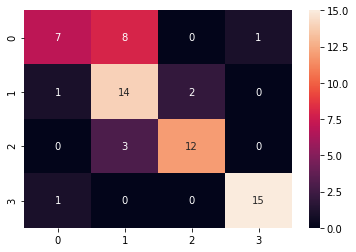

In [0]:
plot_confusion_matrix(trainer)

scores(trainer)

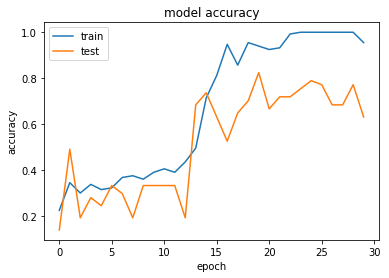

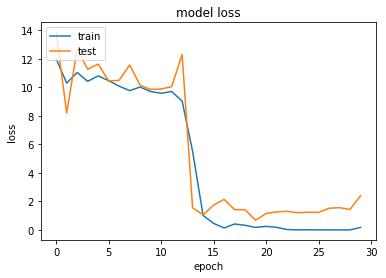

In [0]:
graph(Skeleton_naug)